### OCP LMDB Dataset Tutorial

This notebook provides an overview of how to create LMDB datasets to be used with the OCP repo. This tutorial is intended for those who wish to use OCP to train on their own datasets. Those interested in just using OCP data need not worry about these steps as they've been automated as part of the download script: https://github.com/Open-Catalyst-Project/ocp/blob/master/scripts/download_data.py.

In [1]:
import sys
sys.path.append(r"D:\Train_thử\fairchem-tio2-s2ef")

In [2]:
from ocpmodels.preprocessing import AtomsToGraphs
from ocpmodels.datasets import SinglePointLmdbDataset, TrajectoryLmdbDataset
import ase.io
from ase.build import bulk
from ase.build import fcc100, add_adsorbate, molecule
from ase.constraints import FixAtoms
from ase.calculators.emt import EMT
from ase.optimize import BFGS
import matplotlib.pyplot as plt
import lmdb
import pickle
from tqdm import tqdm
import torch
import os

### Structure to Energy and Forces (S2EF) LMDBs

S2EF LMDBs utilize the TrajectoryLmdb dataset. This dataset expects a directory of LMDB files. In addition to the attributes defined by AtomsToGraph, the following attributes must be added for the S2EF task:

- tags (optional): 0 - subsurface, 1 - surface, 2 - adsorbate
- fid: Frame index along the trajcetory
- sid- sid: Unique system identifier, arbitrary

Additionally, a "length" key must be added to each LMDB file.

As a demo, we will use the above generated data to create an S2EF LMDB dataset

In [3]:
import lmdb
import pickle

# Your specific path
file_path = r"D:\Train_thử\fairchem-tio2-s2ef\tutorials\s2ef\data.0007.lmdb"
# Open the LMDB environment
# We use subdir=False because we are pointing to a file, not a directory
env = lmdb.open(file_path, subdir=False, readonly=True, lock=False)

with env.begin() as txn:
    # Check how many entries are in this shard
    count = txn.stat()['entries']
    print(f"Successfully opened! Total entries in this file: {count}")
    
    # Let's read the very first entry
    cursor = txn.cursor()
    cursor.first()
    
    key, value = cursor.item()
    data = pickle.loads(value)
    
    print("\n--- Content of the first entry ---")
    print(f"Key: {key.decode('utf-8')}")
    
    # If this is MACE-OCP data, it usually contains these keys:
    if isinstance(data, dict):
        for k, v in data.items():
            # We print the shape/type of the data instead of the whole thing to keep it clean
            if hasattr(v, 'shape'):
                print(f"{k}: Tensor of shape {v.shape}")
            else:
                print(f"{k}: {v}")

env.close()

Successfully opened! Total entries in this file: 25001

--- Content of the first entry ---
Key: 0


In [4]:
os.makedirs("s2ef", exist_ok=True)
# db = lmdb.open(
#     "s2ef/data.0001.lmdb",
#     map_size=1024 * 1024 * 1024,
#     subdir=False,
#     meminit=False,
#     map_async=True,
# )

file_path = r"D:\Train_thử\fairchem-tio2-s2ef\tutorials\s2ef\data.0007.lmdb"

env = lmdb.open(
    file_path,
    subdir=False,
    readonly=True,
    lock=False,
    readahead=False
)

In [7]:
# dataset = TrajectoryLmdbDataset({"src": "s2ef/"})
dataset = TrajectoryLmdbDataset({"src": r"D:\Train_thử\fairchem-tio2-s2ef\tutorials\s2ef"})
len(dataset)

c:\Users\admin\anaconda3\envs\tio2-s2ef\lib\site-packages\IPython\core\interactiveshell.py:3550: UserWarning: TrajectoryLmdbDataset is deprecated and will be removed in the future.Please use 'LmdbDataset' instead.
  exec(code_obj, self.user_global_ns, self.user_ns)


25000

In [8]:
dataset[0]

Data(pos=[87, 3], cell=[1, 3, 3], atomic_numbers=[87], natoms=87, tags=[87], y=-802.37609902, force=[87, 3], fixed=[87], sid=1960640, fid=181, id='0_0')

#### Advanced usage

TrajectoryLmdbDataset supports multiple LMDB files because the need to highly parallelize the dataset construction process. With OCP's largest split containing 135M+ frames, the need to parallelize the LMDB generation process for these was necessary. If you find yourself needing to deal with very large datasets we recommend parallelizing this process.

### Interacting with the LMDBs

Below we demonstrate how to interact with an LMDB to extract particular information.

In [5]:
dataset = TrajectoryLmdbDataset({"src": "s2ef/"})

c:\Users\admin\anaconda3\envs\tio2-s2ef\lib\site-packages\IPython\core\interactiveshell.py:3550: UserWarning: TrajectoryLmdbDataset is deprecated and will be removed in the future.Please use 'LmdbDataset' instead.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [6]:
data = dataset[0]
data

Data(pos=[87, 3], cell=[1, 3, 3], atomic_numbers=[87], natoms=87, tags=[87], y=-802.37609902, force=[87, 3], fixed=[87], sid=1960640, fid=181, id='0_0')

In [11]:
from ase.data import chemical_symbols

# Assuming 'data' is your dataset[0]
atom_list = [chemical_symbols[int(z)] for z in data.atomic_numbers]

print(f"Elements in this system: {atom_list}")

# To see which atoms are the 'adsorbate' (molecule) vs 'surface'
for i, symbol in enumerate(atom_list):
    tag = data.tags[i].item()
    role = "Subsurface" if tag == 0 else "Surface" if tag == 1 else "Adsorbate"
    print(f"Atom {i}: {symbol} ({role}) at {data.pos[i].tolist()}")

Elements in this system: ['Hf', 'Hf', 'Hf', 'Hf', 'Hf', 'Hf', 'Hf', 'Hf', 'Hf', 'Hf', 'Hf', 'Hf', 'Hf', 'Hf', 'Hf', 'Hf', 'Hf', 'Hf', 'Hf', 'Hf', 'Nb', 'Nb', 'Nb', 'Nb', 'Nb', 'Nb', 'Nb', 'Nb', 'Nb', 'Nb', 'Nb', 'Nb', 'Nb', 'Nb', 'Nb', 'Nb', 'Nb', 'Nb', 'Nb', 'Nb', 'Tc', 'Tc', 'Tc', 'Tc', 'Tc', 'Tc', 'Tc', 'Tc', 'Tc', 'Tc', 'Tc', 'Tc', 'Tc', 'Tc', 'Tc', 'Tc', 'Tc', 'Tc', 'Tc', 'Tc', 'Tc', 'Tc', 'Tc', 'Tc', 'Tc', 'Tc', 'Tc', 'Tc', 'Tc', 'Tc', 'Tc', 'Tc', 'Tc', 'Tc', 'Tc', 'Tc', 'Tc', 'Tc', 'Tc', 'Tc', 'C', 'C', 'H', 'H', 'H', 'H', 'O']
Atom 0: Hf (Subsurface) at [0.0, 0.35395902395248413, 14.468790054321289]
Atom 1: Hf (Subsurface) at [0.0, 7.602142810821533, 11.265515327453613]
Atom 2: Hf (Subsurface) at [0.0, 6.696119785308838, 15.750100135803223]
Atom 3: Hf (Surface) at [0.016421189531683922, 5.714548110961914, 20.1619815826416]
Atom 4: Hf (Subsurface) at [0.0, 13.038280487060547, 17.031410217285156]
Atom 5: Hf (Subsurface) at [2.287595748901367, 3.0720279216766357, 17.35173797607422

### Visualization

In [7]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

In [8]:
from ase import Atoms
from ase.visualize import view
import torch

# 1. Extract the information from your Data object
# We reshape the cell from [1, 3, 3] to [3, 3]
positions = data.pos.numpy()
numbers = data.atomic_numbers.numpy().astype(int)
cell = data.cell.view(3, 3).numpy()

# 2. Create the ASE Atoms object
structure = Atoms(
    numbers=numbers,
    positions=positions,
    cell=cell,
    pbc=True # Periodic Boundary Conditions are standard for OCP
)

# 3. Open the visualizer
view(structure)

# Optional: Save it as a 3D file for VESTA or Ovito
structure.write("system_2090899_frame_206.xyz")

In [9]:
energies = torch.tensor([data.y for data in dataset])
len(energies)

25000

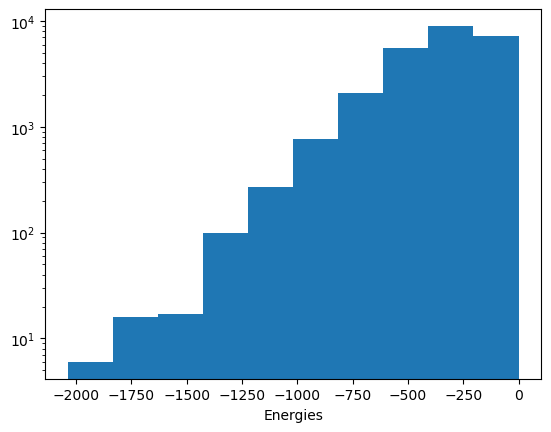

In [10]:
plt.hist(energies, bins = 10)
plt.yscale("log")
plt.xlabel("Energies")
plt.show()

### 3D Visualization

In [ ]:
import ase.io
from ase import Atoms
import torch

# 1. Access the specific data object (e.g., sid 2090899, fid 206)
data = dataset[0] 

# 2. Convert to ASE Atoms object
# Reshape the cell to [3, 3] as required by ASE
atoms = Atoms(
    numbers=data.atomic_numbers.numpy().astype(int),
    positions=data.pos.numpy(),
    cell=data.cell.view(3, 3).numpy(),
    pbc=True
)

# 3. Attach metadata (This makes it "Extended")
# We store energy and forces so other models or Ovito can read them
atoms.info["energy"] = data.y.item() if isinstance(data.y, torch.Tensor) else data.y
atoms.arrays["forces"] = data.force.numpy()
atoms.info["sid"] = str(data.sid)
atoms.info["fid"] = str(data.fid)

# 4. Save as ExtXYZ
ase.io.write("system_data.extxyz", atoms, format="extxyz")

In [31]:
from ase.visualize import view
import ase.io

# 1. Đọc dữ liệu từ file ExtXYZ bạn đã tạo
atoms = ase.io.read("system_data.extxyz")

# 2. Hiển thị bằng viewer 'x3d' (nó sẽ hiện ra một cửa sổ tương tác 3D)
view(atoms, viewer='x3d')